In [71]:
import pandas as pd
import numpy as np
import atoti as tt
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Read Data

In [40]:
# df_traffic_26 = pd.read_csv('datasets/tomtom_2022-11-26.csv')
# df_traffic_28 = pd.read_csv('datasets/tomtom_2022-11-28.csv')
df_weather = pd.read_csv('datasets/Weather_2022-11-29.csv')
df_traffic = pd.read_csv('datasets/tomtom_2022-11-29.csv')

In [41]:
df_traffic

,timestamp,date_time,traffic_index,jams_count,jams_length,jams_delay,traffic_index_weekago,weekday
0,1669200390,2022-11-23 17:46:30.000,72,775,575.6,3957.5,71,Wednesday
1,1669201290,2022-11-23 18:01:30.000,78,738,555.5,3883.1,74,Wednesday
2,1669204890,2022-11-23 19:01:30.000,67,436,354.9,2088.1,67,Wednesday
3,1669208490,2022-11-23 20:01:30.001,43,175,147.5,777.1,45,Wednesday
4,1669212090,2022-11-23 21:01:30.001,21,53,48.4,234.7,24,Wednesday
...,...,...,...,...,...,...,...,...
164,1669788090,2022-11-30 13:01:30.001,50,449,330.0,2046.2,37,Wednesday
165,1669791690,2022-11-30 14:01:30.001,47,408,286.3,1874.4,42,Wednesday
166,1669795290,2022-11-30 15:01:30.001,47,426,312.9,2125.0,48,Wednesday
167,1669801590,2022-11-30 16:46:30.000,54,510,401.5,2444.7,56,Wednesday


In [42]:
df_weather

,date_time,time,weathervalue,precipMM
0,2022-11-22 00:00:00,0,Clear,0.0
1,2022-11-22 01:00:00,1,Clear,0.0
2,2022-11-22 02:00:00,2,Clear,0.0
3,2022-11-22 03:00:00,3,Clear,0.0
4,2022-11-22 04:00:00,4,Clear,0.0
...,...,...,...,...
187,2022-11-29 19:00:00,19,Light rain shower,0.2
188,2022-11-29 20:00:00,20,Moderate or heavy rain shower,1.1
189,2022-11-29 21:00:00,21,Moderate or heavy rain shower,1.4
190,2022-11-29 22:00:00,22,Moderate or heavy rain shower,0.7


### Data Normalization

- Normalize date_time format to hh:00:00
- Add `traffic_category` column to categorize `traffic_index` quantitative attribute

In [43]:
# df_traffic_merge = pd.concat([df_traffic_26, df_traffic_28], ignore_index=True)
df_traffic['date_time'] = df_traffic['date_time'].apply(lambda x: x.split(' ')[0] + " " + x.split(' ')[1][:3] + "00:00")
df_traffic['traffic_category'] = df_traffic['traffic_index'].apply(lambda t: "Empty" if t<25 else "Fluid" if t<50 else "Heavy" if t<75 else "Jam")

In [44]:
df_weather['weather_index'] = df_weather['weathervalue'].apply(lambda t: 1 if t=="Sunny" else 
                                                               2 if t=="Clear" else 
                                                               3 if t=="Partly cloudy" else 
                                                               4 if t=="Cloudy" else 
                                                               5 if t=="Overcast" else 
                                                               6 if t=="Patchy rain possible" else 
                                                               7 if t=="Patch light drizzle" else
                                                               8 if t=="Light drizzle" else
                                                               9 if t=="Light rain shower" else
                                                               10)

In [45]:
df_weather.isnull().sum()

date_time        0
time             0
weathervalue     0
precipMM         0
weather_index    0
dtype: int64

In [46]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              169 non-null    int64  
 1   date_time              169 non-null    object 
 2   traffic_index          169 non-null    int64  
 3   jams_count             169 non-null    int64  
 4   jams_length            169 non-null    float64
 5   jams_delay             169 non-null    float64
 6   traffic_index_weekago  169 non-null    int64  
 7   weekday                169 non-null    object 
 8   traffic_category       169 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 12.0+ KB


In [47]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_time      192 non-null    object 
 1   time           192 non-null    int64  
 2   weathervalue   192 non-null    object 
 3   precipMM       192 non-null    float64
 4   weather_index  192 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ KB


In [48]:
df_weather

,date_time,time,weathervalue,precipMM,weather_index
0,2022-11-22 00:00:00,0,Clear,0.0,2
1,2022-11-22 01:00:00,1,Clear,0.0,2
2,2022-11-22 02:00:00,2,Clear,0.0,2
3,2022-11-22 03:00:00,3,Clear,0.0,2
4,2022-11-22 04:00:00,4,Clear,0.0,2
...,...,...,...,...,...
187,2022-11-29 19:00:00,19,Light rain shower,0.2,9
188,2022-11-29 20:00:00,20,Moderate or heavy rain shower,1.1,10
189,2022-11-29 21:00:00,21,Moderate or heavy rain shower,1.4,10
190,2022-11-29 22:00:00,22,Moderate or heavy rain shower,0.7,10


In [49]:
df_traffic.head()

,timestamp,date_time,traffic_index,jams_count,jams_length,jams_delay,traffic_index_weekago,weekday,traffic_category
0,1669200390,2022-11-23 17:00:00,72,775,575.6,3957.5,71,Wednesday,Heavy
1,1669201290,2022-11-23 18:00:00,78,738,555.5,3883.1,74,Wednesday,Jam
2,1669204890,2022-11-23 19:00:00,67,436,354.9,2088.1,67,Wednesday,Heavy
3,1669208490,2022-11-23 20:00:00,43,175,147.5,777.1,45,Wednesday,Fluid
4,1669212090,2022-11-23 21:00:00,21,53,48.4,234.7,24,Wednesday,Empty


### Data Merging

In [50]:
df_merge = pd.merge(df_traffic, df_weather, left_on='date_time', right_on='date_time')
df_merge

,timestamp,date_time,traffic_index,jams_count,jams_length,jams_delay,traffic_index_weekago,weekday,traffic_category,time,weathervalue,precipMM,weather_index
0,1669200390,2022-11-23 17:00:00,72,775,575.6,3957.5,71,Wednesday,Heavy,17,Patchy rain possible,0.0,6
1,1669201290,2022-11-23 18:00:00,78,738,555.5,3883.1,74,Wednesday,Jam,18,Patchy rain possible,0.0,6
2,1669204890,2022-11-23 19:00:00,67,436,354.9,2088.1,67,Wednesday,Heavy,19,Patchy rain possible,0.0,6
3,1669208490,2022-11-23 20:00:00,43,175,147.5,777.1,45,Wednesday,Fluid,20,Partly cloudy,0.0,3
4,1669212090,2022-11-23 21:00:00,21,53,48.4,234.7,24,Wednesday,Empty,21,Partly cloudy,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1669723290,2022-11-29 19:00:00,69,511,418.2,2573.7,58,Tuesday,Heavy,19,Light rain shower,0.2,9
147,1669726890,2022-11-29 20:00:00,50,260,230.0,1440.6,40,Tuesday,Heavy,20,Moderate or heavy rain shower,1.1,10
148,1669730490,2022-11-29 21:00:00,29,95,90.7,458.8,20,Tuesday,Fluid,21,Moderate or heavy rain shower,1.4,10
149,1669734090,2022-11-29 22:00:00,15,48,60.0,239.0,9,Tuesday,Empty,22,Moderate or heavy rain shower,0.7,10


In [51]:
df_rushhour_morning = df_merge.loc[(df_merge['date_time'].str.contains('06:00:00|07:00:00|08:00:00', regex=True))& (df_merge['weekday'] != 'Sunday'), :]
df_rushhour_afternoon = df_merge.loc[(df_merge['date_time'].str.contains('16:00:00|17:00:00|18:00:00', regex=True)) & (df_merge['weekday'] != 'Sunday'), :]
df_rushhour = df_merge.loc[(df_merge['date_time'].str.contains('07:00:00|08:00:00|16:00:00|17:00:00|18:00:00', regex=True)) & (df_merge['weekday'] != 'Sunday' ) & (df_merge['weekday'] != 'Saturday' ), :]

In [73]:
df_rushhour.head(20)

,timestamp,date_time,traffic_index,jams_count,jams_length,jams_delay,traffic_index_weekago,weekday,traffic_category,time,weathervalue,precipMM,weather_index
0,1669200390,2022-11-23 17:00:00,72,775,575.6,3957.5,71,Wednesday,Heavy,17,Patchy rain possible,0.0,6
1,1669201290,2022-11-23 18:00:00,78,738,555.5,3883.1,74,Wednesday,Jam,18,Patchy rain possible,0.0,6
14,1669250790,2022-11-24 07:00:00,43,387,259.1,1763.0,79,Thursday,Fluid,7,Partly cloudy,0.0,3
15,1669251690,2022-11-24 08:00:00,44,382,275.9,1713.8,83,Thursday,Fluid,8,Sunny,0.0,1
23,1669283190,2022-11-24 16:00:00,53,541,384.0,2558.6,62,Thursday,Heavy,16,Partly cloudy,0.0,3
24,1669286790,2022-11-24 17:00:00,68,801,557.2,4049.4,83,Thursday,Heavy,17,Partly cloudy,0.0,3
25,1669287690,2022-11-24 18:00:00,72,776,562.9,3993.6,88,Thursday,Heavy,18,Partly cloudy,0.0,3
38,1669337190,2022-11-25 07:00:00,36,313,213.7,1369.6,38,Friday,Fluid,7,Partly cloudy,0.0,3
39,1669338090,2022-11-25 08:00:00,36,299,202.6,1302.6,38,Friday,Fluid,8,Cloudy,0.0,4
47,1669369590,2022-11-25 16:00:00,59,589,457.0,2850.0,58,Friday,Heavy,16,Light rain shower,0.3,9


### Data Visualization and Regression Model

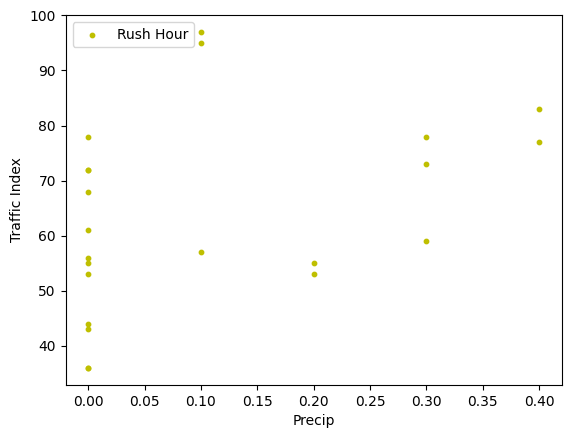

In [79]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.xlabel('Precip') 
plt.ylabel('Traffic Index') 

ax1.scatter(df_rushhour['precipMM'], df_rushhour['traffic_index'], s=10, c='y', marker="o", label='Rush Hour')
plt.legend(loc='upper left')
plt.show()

In [30]:
df_rushhour

,timestamp,date_time,traffic_index,jams_count,jams_length,jams_delay,traffic_index_weekago,weekday,traffic_category,time,weathervalue,precipMM,weather_index
0,1669200390,2022-11-23 17:00:00,72,775,575.6,3957.5,71,Wednesday,Heavy,17,Patchy rain possible,0.0,6
1,1669201290,2022-11-23 18:00:00,78,738,555.5,3883.1,74,Wednesday,Jam,18,Patchy rain possible,0.0,6
14,1669250790,2022-11-24 07:00:00,43,387,259.1,1763.0,79,Thursday,Fluid,7,Partly cloudy,0.0,3
15,1669251690,2022-11-24 08:00:00,44,382,275.9,1713.8,83,Thursday,Fluid,8,Sunny,0.0,1
23,1669283190,2022-11-24 16:00:00,53,541,384.0,2558.6,62,Thursday,Heavy,16,Partly cloudy,0.0,3
24,1669286790,2022-11-24 17:00:00,68,801,557.2,4049.4,83,Thursday,Heavy,17,Partly cloudy,0.0,3
25,1669287690,2022-11-24 18:00:00,72,776,562.9,3993.6,88,Thursday,Heavy,18,Partly cloudy,0.0,3
38,1669337190,2022-11-25 07:00:00,36,313,213.7,1369.6,38,Friday,Fluid,7,Partly cloudy,0.0,3
39,1669338090,2022-11-25 08:00:00,36,299,202.6,1302.6,38,Friday,Fluid,8,Cloudy,0.0,4
47,1669369590,2022-11-25 16:00:00,59,589,457.0,2850.0,58,Friday,Heavy,16,Light rain shower,0.3,9


In [57]:
X = np.array(df_rushhour['precipMM']).reshape(-1, 1)
y = np.array(df_rushhour['traffic_index']).reshape(-1, 1)
  
# # Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# Splitting the data into training and testing data
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.13694065809498845


In [77]:
print(f"Slope: {regr.coef_}, Intercept: {regr.intercept_}")

Slope: [[44.04]], Intercept: [60.012]


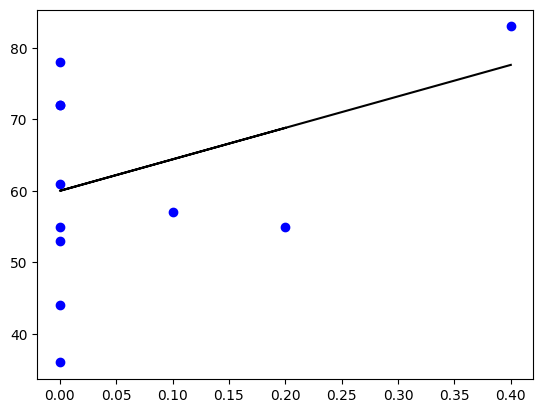

In [58]:
y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')
  
plt.show()

### Data Cube

In [66]:
session = tt.Session()

In [67]:
traffic_weather_tt = session.read_pandas(df_merge, keys=["date_time"], table_name="Traffic")

In [68]:
cube = session.create_cube(traffic_weather_tt)

In [16]:
l = cube.levels
h = cube.hierarchies
m = cube.measures

m

Measures()

### Data Mining using Apriori

In [59]:
df_filter = pd.pivot_table(df_merge, values=['traffic_category'], index=['weathervalue'], columns=['date_time'], aggfunc=np.sum)
df_filter

traffic_category                      \
date_time                     2022-11-23 17:00:00 2022-11-23 18:00:00   
weathervalue                                                            
Clear                                         NaN                 NaN   
Cloudy                                        NaN                 NaN   
Light drizzle                                 NaN                 NaN   
Light rain shower                             NaN                 NaN   
Moderate or heavy rain shower                 NaN                 NaN   
Overcast                                      NaN                 NaN   
Partly cloudy                                 NaN                 NaN   
Patchy light drizzle                          NaN                 NaN   
Patchy rain possible                        Heavy                 Jam   
Sunny                                         NaN                 NaN   

                                                                       \
date_time                     2022-11-23 19:00:00 2022-11-23 20:00:00   
weathervalue                                                            
Clear                                         NaN                 NaN   
Cloudy                                        NaN                 NaN   
Light drizzle                                 NaN                 NaN   
Light rain shower                             NaN                 NaN   
Moderate or heavy rain shower                 NaN                 NaN   
Overcast                                      NaN                 NaN   
Partly cloudy                                 NaN               Fluid   
Patchy light drizzle                          NaN                 NaN   
Patchy rain possible                        Heavy                 NaN   
Sunny                                         NaN                 NaN   

                                                                       \
date_time                     2022-11-23 21:00:00 2022-11-23 22:00:00   
weathervalue                                                            
Clear                                         NaN                 NaN   
Cloudy                                        NaN                 NaN   
Light drizzle                                 NaN                 NaN   
Light rain shower                             NaN                 NaN   
Moderate or heavy rain shower                 NaN                 NaN   
Overcast                                      NaN                 NaN   
Partly cloudy                               Empty               Empty   
Patchy light drizzle                          NaN                 NaN   
Patchy rain possible                          NaN                 NaN   
Sunny                                         NaN                 NaN   

                                                                       \
date_time                     2022-11-23 23:00:00 2022-11-24 00:00:00   
weathervalue                                                            
Clear                                         NaN                 NaN   
Cloudy                                        NaN                 NaN   
Light drizzle                                 NaN                 NaN   
Light rain shower                             NaN                 NaN   
Moderate or heavy rain shower                 NaN                 NaN   
Overcast                                      NaN                 NaN   
Partly cloudy                                 NaN                 NaN   
Patchy light drizzle                          NaN                 NaN   
Patchy rain possible                        Empty               Empty   
Sunny                                         NaN                 NaN   

                                                                       ...  \
date_time                     2022-11-24 01:00:00 2022-11-24 02:00:00  ...   
weathervalue                                                           ...   

In [60]:
itemsetList = []
dflist = df_filter.values.tolist()
dfindex = df_filter.index.tolist()

for i in range (len(df_filter)):
    currentList = [dflist[i][item] for item in range(len(dflist[i])) if not(pd.isnull(dflist[i][item])) == True]
    itemsetList.append(currentList)
    
itemsetList

[['Empty', 'Empty', 'Empty', 'Fluid', 'Empty', 'Empty'],
 ['Empty',
  'Empty',
  'Empty',
  'Fluid',
  'Fluid',
  'Fluid',
  'Heavy',
  'Fluid',
  'Fluid'],
 ['Empty', 'Empty', 'Empty'],
 ['Empty',
  'Empty',
  'Empty',
  'Heavy',
  'Heavy',
  'Heavy',
  'Jam',
  'Jam',
  'Jam',
  'Empty',
  'Empty',
  'Empty',
  'Fluid',
  'Fluid',
  'Fluid',
  'Fluid',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Fluid',
  'Heavy',
  'Heavy',
  'Heavy',
  'Fluid',
  'Jam',
  'Jam',
  'Jam',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Heavy',
  'Heavy',
  'Fluid',
  'Heavy',
  'Jam',
  'Heavy',
  'Empty'],
 ['Heavy', 'Fluid', 'Empty'],
 ['Heavy', 'Heavy', 'Heavy'],
 ['Fluid',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Fluid',
  'Fluid',
  'Fluid',
  'Heavy',
  'Heavy',
  'Heavy',
  'Heavy',
  'Empty',
  'Empty',
  'Fluid',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Empty',
  'Fluid',
  'Jam',
  'Jam',
  'Jam',
  

In [61]:
cleanedList = [[] for _ in range(len(itemsetList))]

for i in range(len(itemsetList)):
    for item in itemsetList[i]:
        if item in cleanedList[i]:
            continue
        else:
            cleanedList[i].append(item)

cleanedList        

[['Empty', 'Fluid'],
 ['Empty', 'Fluid', 'Heavy'],
 ['Empty'],
 ['Empty', 'Heavy', 'Jam', 'Fluid'],
 ['Heavy', 'Fluid', 'Empty'],
 ['Heavy'],
 ['Fluid', 'Empty', 'Heavy', 'Jam'],
 ['Empty'],
 ['Heavy', 'Jam', 'Empty', 'Fluid'],
 ['Fluid']]

In [62]:
te = TransactionEncoder()
te_ary = te.fit(cleanedList).transform(cleanedList)

In [63]:
df_try = pd.DataFrame(te_ary, columns=te.columns_)
df_try

,Empty,Fluid,Heavy,Jam
0,True,True,False,False
1,True,True,True,False
2,True,False,False,False
3,True,True,True,True
4,True,True,True,False
5,False,False,True,False
6,True,True,True,True
7,True,False,False,False
8,True,True,True,True
9,False,True,False,False


In [64]:
frequent_itemsets = apriori(df_try, min_support=0.5, use_colnames=True)
frequent_itemsets.set_index(pd.Index(dfindex[:len(frequent_itemsets)]), inplace=True)

frequent_itemsets

,support,itemsets
Clear,0.8,(Empty)
Cloudy,0.7,(Fluid)
Light drizzle,0.6,(Heavy)
Light rain shower,0.6,"(Empty, Fluid)"
Moderate or heavy rain shower,0.5,"(Empty, Heavy)"
Overcast,0.5,"(Heavy, Fluid)"
Partly cloudy,0.5,"(Empty, Heavy, Fluid)"


In [65]:
from mlxtend.frequent_patterns import association_rules
res = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
res.set_index(pd.Index(dfindex[:len(res)]), inplace=True)

res = res[['antecedents', 'consequents', 'support', 'confidence']]
res

,antecedents,consequents,support,confidence
Clear,(Empty),(Fluid),0.6,0.750000
Cloudy,(Fluid),(Empty),0.6,0.857143
Light drizzle,(Heavy),(Empty),0.5,0.833333
Light rain shower,(Heavy),(Fluid),0.5,0.833333
Moderate or heavy rain shower,(Fluid),(Heavy),0.5,0.714286
Overcast,"(Empty, Heavy)",(Fluid),0.5,1.000000
Partly cloudy,"(Empty, Fluid)",(Heavy),0.5,0.833333
Patchy light drizzle,"(Heavy, Fluid)",(Empty),0.5,1.000000
Patchy rain possible,(Heavy),"(Empty, Fluid)",0.5,0.833333
Sunny,(Fluid),"(Empty, Heavy)",0.5,0.714286
